In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('D3.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142219 entries, 0 to 142218
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           142219 non-null  int64  
 1   Month          142219 non-null  int64  
 2   Location       142219 non-null  object 
 3   MinTemp        142219 non-null  float64
 4   MaxTemp        142219 non-null  float64
 5   Rainfall       142219 non-null  float64
 6   Evaporation    142219 non-null  float64
 7   Sunshine       142219 non-null  float64
 8   WindGustDir    142219 non-null  object 
 9   WindGustSpeed  142219 non-null  int64  
 10  WindDir9am     142219 non-null  object 
 11  WindDir3pm     142219 non-null  object 
 12  WindSpeed9am   142219 non-null  int64  
 13  WindSpeed3pm   142219 non-null  int64  
 14  Humidity9am    142219 non-null  float64
 15  Humidity3pm    142219 non-null  float64
 16  Pressure9am    142219 non-null  float64
 17  Pressure3pm    142219 non-nul

In [2]:
# This block of code will do the processing as mentioned above. The processed data may need further processing for LR and NN. 

# Drop columns that should be removed due to high correlation with other variables
columns_to_drop = ['Year', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
df2 = df.drop(columns=columns_to_drop)

# Create new averaged variables "Temp" and "Pressure" and then drop 4 columns used for creating these variables
df2['Pressure'] = (df2['Pressure9am'] + df2['Pressure3pm'])/2
df2['Temp'] = (df2['MinTemp'] + df2['MaxTemp'])/2
columns_to_drop2 = ['Pressure9am', 'Pressure3pm', 'MinTemp', 'MaxTemp']
df2 = df2.drop(columns=columns_to_drop2)

# Use one-hot encoding for categorical variables
df2 = pd.get_dummies(df2)
print(df2.info())

# Target/input split
y = df2['RainTomorrow']
X = df2.drop(['RainTomorrow'], axis=1)

# Split the data into training and testing data
from sklearn.model_selection import train_test_split

rs = 10
X_mat = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142219 entries, 0 to 142218
Columns: 109 entries, Month to WindDir3pm_WSW
dtypes: bool(97), float64(7), int64(5)
memory usage: 26.2 MB
None


In [3]:
# Normalization/standarization is need for logistic regression because it is sensitive to scales of inputs 

from sklearn.preprocessing import StandardScaler
# initialise a standard scaler object
scaler = StandardScaler()
# visualise min, max, mean and standard dev of data before scaling
print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
format(i, min(col), max(col), np.mean(col), np.std(col)))
# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
X_train = scaler.fit_transform(X_train, y_train)
print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
format(i, min(col), max(col), np.mean(col), np.std(col)))
# use the statistic that you learned from training to transform test data
# NEVER learn from test data, this is supposed to be a set of dataset
# that the model has never seen before
X_test = scaler.transform(X_test)


Before scaling
-------------
Variable #4: min 7, max 135, mean 40.02 and std dev 13.15
After scaling
-------------
Variable #4: min -2.51164382853385, max 7.223836994226553, mean 0.00 and std dev 1.00


In [4]:
# default LR model 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(random_state=rs)
# fit it to training data
model.fit(X_train, y_train)

LogisticRegression(random_state=10)

In [5]:
# training and test accuracy
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
# classification report on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.8454592026357819
Test accuracy: 0.845474148033563
              precision    recall  f1-score   support

           0       0.87      0.95      0.90     33101
           1       0.73      0.49      0.59      9565

    accuracy                           0.85     42666
   macro avg       0.80      0.72      0.75     42666
weighted avg       0.84      0.85      0.83     42666



In [6]:
# grab feature importances from the model and feature name from the original X
coef = model.coef_[0]
feature_names = X.columns
# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)
# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]
for i in indices:
    print(feature_names[i], ':', coef[i])

Humidity3pm : 1.2575405405707245
WindGustSpeed : 0.712362182875908
Sunshine : -0.4146171180130786
Pressure : -0.4008620888176411
WindSpeed3pm : -0.18051364200028416
Rainfall : 0.1597090293472617
Humidity9am : 0.1478183629055911
Location_MountGinini : -0.14612260587547685
Location_Wollongong : -0.11556101856809665
Location_Hobart : -0.1124297395547425
Location_Adelaide : 0.10470470045914947
WindDir3pm_NNW : 0.10274971662688592
WindDir3pm_NW : 0.09626488791390855
Location_Perth : 0.08425870979776662
WindDir3pm_SW : -0.08422003381950915
Temp : 0.08288216262071808
Location_MelbourneAirport : -0.07871454372201715
Location_Brisbane : 0.07854038509067258
Location_NorahHead : -0.07836051423254961
WindDir3pm_N : 0.07828174664716989


In [7]:
from sklearn.model_selection import GridSearchCV

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=10), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000]},
             return_train_score=True)

In [9]:
result_set = cv.cv_results_
# print(result_set)

Total number of models:  10


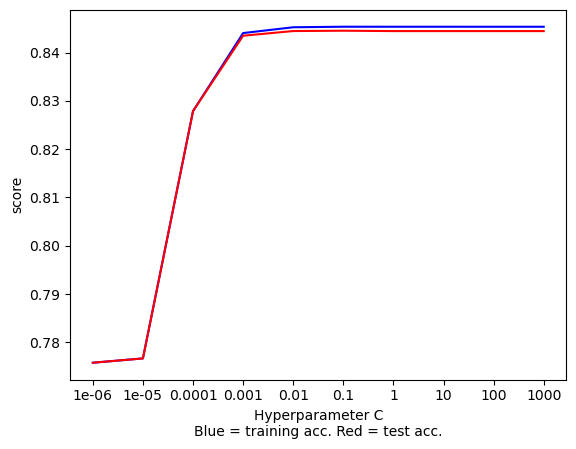

In [10]:
import matplotlib.pyplot as plt

train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

In [11]:
print(cv.best_params_)

{'C': 0.1}


In [12]:
cv.best_estimator_.fit(X_train, y_train)

print("Train accuracy:", cv.best_estimator_.score(X_train, y_train))
print("Test accuracy:", cv.best_estimator_.score(X_test, y_test))

Train accuracy: 0.8454290679336635
Test accuracy: 0.8454975858997796


In [13]:
# slightly overfit when C is larger than 0.001

In [14]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 108
Number of features after elimination 80


In [15]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

In [18]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", rfe_cv.score(X_train_sel, y_train))
print("Test accuracy:", rfe_cv.score(X_test_sel, y_test))

y_pred = rfe_cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(rfe_cv.best_params_)

Train accuracy: 0.8452783944230712
Test accuracy: 0.8452632072376131
              precision    recall  f1-score   support

           0       0.87      0.95      0.90     33101
           1       0.73      0.49      0.59      9565

    accuracy                           0.85     42666
   macro avg       0.80      0.72      0.75     42666
weighted avg       0.84      0.85      0.83     42666

{'C': 0.1}


In [19]:
# Have built 3 regression models (default, CV, CV with reduced variables set)

from sklearn.metrics import roc_auc_score

y_pred_proba_lr = model.predict_proba(X_test)
y_pred_proba_lr_cv = cv.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_sel)

roc_index_lr = roc_auc_score(y_test, y_pred_proba_lr[:, 1])
roc_index_lr_cv = roc_auc_score(y_test, y_pred_proba_lr_cv[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])

print("ROC index on test for `model`:", roc_index_lr)
print("ROC index on test for `cv`:", roc_index_lr_cv)
print("ROC index on test for `rfe_cv`:", roc_index_rfe_cv)

ROC index on test for `model`: 0.8671098307950798
ROC index on test for `cv`: 0.86711555706368
ROC index on test for `rfe_cv`: 0.8670484336989297


In [20]:
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr[:,1])
fpr_lr_cv, tpr_lr_cv, thresholds_lr_cv = roc_curve(y_test, y_pred_proba_lr_cv[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])

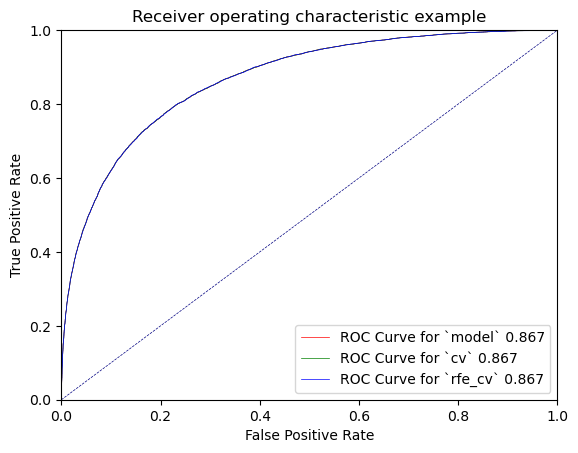

In [21]:
import matplotlib.pyplot as plt

plt.plot(fpr_lr, tpr_lr, label='ROC Curve for `model` {:.3f}'.format(roc_index_lr), color='red', lw=0.5)
plt.plot(fpr_lr_cv, tpr_lr_cv, label='ROC Curve for `cv` {:.3f}'.format(roc_index_lr_cv), color='green', lw=0.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='ROC Curve for `rfe_cv` {:.3f}'.format(roc_index_rfe_cv), color='blue', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()